In [1]:
import numpy as np
import cgi,os
import cv2
from sklearn.cluster import KMeans
from collections import Counter
import imutils
from matplotlib import pyplot as plt
import sys

In [2]:
rgb_lower = [141,85,36]
rgb_higher = [255,219,172]

In [3]:
skin_shades = {
    'dark' : [rgb_lower,[198,134,66]],
    'mild' : [[198,134,66],[224,172,105]],
    'fair':[[224,172,105],[241,194,125]],
    'bright' : [[241,194,125],rgb_higher]
}

In [4]:
skintones = {}
for shade in skin_shades:
    skintones.update({
        shade : [
            (skin_shades[shade][0][0] * 256 * 256) + (skin_shades[shade][0][1] * 256) + skin_shades[shade][0][2],
            (skin_shades[shade][1][0] * 256 * 256) + (skin_shades[shade][1][1] * 256) + skin_shades[shade][1][2]
        ]
    })

In [5]:
#defining skin extracting function
def Skin_extract(image):
    img = image.copy()
    black_img = np.zeros((img.shape[0],img.shape[1],img.shape[2]),dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    print(lower_threshold)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)
    print(upper_threshold)

    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)
    skin = cv2.bitwise_and(img, img, mask=skinMask)
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)

In [6]:
#defining remove black function
def removeBlack(estimator_labels, estimator_cluster):
    hasBlack = False
    occurance_counter = Counter(estimator_labels)
    def compare(x, y): return Counter(x) == Counter(y)
    for x in occurance_counter.most_common(len(estimator_cluster)):
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]
        if compare(color, [0, 0, 0]) == True:
            del occurance_counter[x[0]]
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break
    return (occurance_counter, estimator_cluster, hasBlack)

In [7]:
# defining the fuction to get the color information from an image
def getColorInfo(estimator_labels, estimator_cluster, hasThresholding=False):
    occurance_counter = None
    colorInformation = []
    hasBlack = False
    if hasThresholding == True:
        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black
    else:
        occurance_counter = Counter(estimator_labels)
    totalOccurance = sum(occurance_counter.values())
    for x in occurance_counter.most_common(len(estimator_cluster)):
        index = (int(x[0]))
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index
        color = estimator_cluster[index].tolist()
        color_percentage = (x[1]/totalOccurance)
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}
        colorInformation.append(colorInfo)
    return colorInformation

In [8]:
def extractDominantColor(image, number_of_colors=1, hasThresholding=False):
    if hasThresholding == True:
        number_of_colors += 1
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.reshape((img.shape[0]*img.shape[1]), 3)
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)
    estimator.fit(img)
    colorInformation = getColorInfo(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

In [9]:
def plotColorBar(colorInformation):
    color_bar = np.zeros((100, 600, 3), dtype="uint8")
    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])
        color = tuple(map(int, (x['color'])))
        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar


In [10]:

url = input("Enter image url :")

Enter image url :https://pbs.twimg.com/profile_images/888341377729273856/OJGYfJTs_400x400.jpg


In [11]:
image = imutils.url_to_image(url)

Text(0.5, 1.0, 'Original Image')

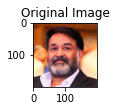

In [12]:
image = imutils.resize(image, width=200)
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

[ 0 48 80]
[ 20 255 255]


Text(0.5, 1.0, 'Thresholded  Image')

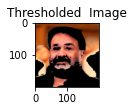

In [13]:
skin = Skin_extract(image)
plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")

In [14]:

unprocessed_dominant = extractDominantColor(skin, number_of_colors=1, hasThresholding=True)

In [15]:
decimal_lower = (rgb_lower[0] * 256 * 256) + (rgb_lower[1] * 256) + rgb_lower[2]
decimal_higher = (rgb_higher[0] * 256 * 256) + (rgb_higher[1] * 256) + rgb_higher[2]
dominantColors = []

In [16]:
for clr in unprocessed_dominant:
    clr_decimal = int((clr['color'][0] * 256 * 256) + (clr['color'][1] * 256) + clr['color'][2])
    if clr_decimal in range(decimal_lower,decimal_higher+1):
        clr['decimal_color'] = clr_decimal
        dominantColors.append(clr)

In [17]:

skin_tones = []
if len(dominantColors) == 0:
    skin_tones.append('Unrecognized')
else:
    for color in dominantColors:
        for shade in skintones:
            if color['decimal_color'] in range(skintones[shade][0],skintones[shade][1]+1):
                skin_tones.append(shade)


In [18]:
print(skin_tones)

['mild']


Color Bar


Text(0.5, 1.0, 'Color Bar')

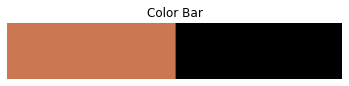

In [19]:

print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

In [20]:

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>